In [5]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


## Lorenz system (nonlinear ODE)

The Lorenz system serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$

with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$ for this example. We generate our training data starting from the initial condition $(-8, 8, 27)$. Note that for this example we also collect measurements of derivatives of state variables, $(\dot x, \dot y, \dot z)$.

In [6]:
def dU_dt_true(U):
    """
    returns the right hand side of the differential equation"""
    sigma = 10
    rho = 28
    beta = 8/3
    return [sigma*(U[1]-U[0]), U[0]*(rho - U[2])-U[1], U[0]*U[1] - beta*U[2]]


def dU_dt_sin(U, t):
    """
    returns the right hand side of the differential equation"""
    return dU_dt_true(U)

We then define a function that solves the ODE and then ensures that 
both coordinates and data get a shape of n_samples x feature and
be returned as (coordinate, data)

In [7]:
dt = 0.001
x0_train = [-8, 8, 27]
def create_data(U0=x0_train, ts=np.arange(0, 100, dt)):
    """
    Creates data which is the solution of the simple ODE system example.
    the output has torch.float32 format.
    
    Args: 
        U0: Initial condition
        ts: Time points to evaluate the ODE at.
    """
    Y = torch.from_numpy(odeint(dU_dt_sin, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    return T, Y

Thus we take unnormalized but also randomly subsample the data applying small amound of noise:

Preprocessing data
Dataset is using device:  cuda


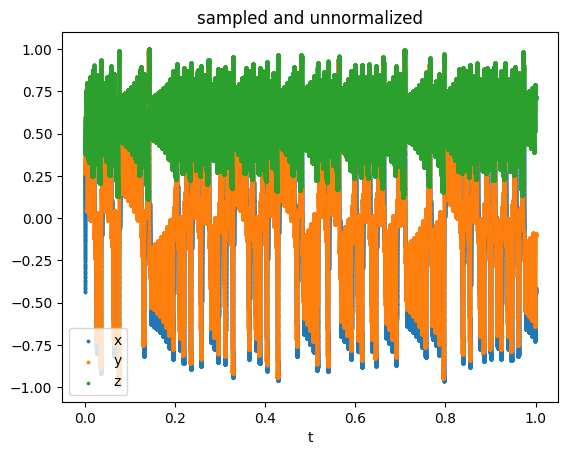

In [8]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 100000},
    preprocess_kwargs={"noise_level": 0,  
        "normalize_coords": True,
        "normalize_data": True,},
    apply_normalize=custom_normalize,
    device=device
)
dataset.data.shape
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="x", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="y", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 2].cpu(), label="z", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("sampled and unnormalized")
plt.show()

Now we need to split our data into a train and test dataloaders for PyTorch

In [9]:
 # see deepymod.data.base.get_train_test_loader for definition of `get_train_test_loader` function.
 # the shuffle is completely random mixing latter and earlier times
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [10]:
from deepymod.model.library import Library1D
library = Library1D(poly_order=1, diff_order=0) 
estimator = Threshold(0.1)
constraint = LeastSquares()
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
network = NN(1, [30, 30, 30, 30], 3)
model = DeepMoD(network, library, estimator, constraint).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [11]:
%%time
! rm -rf ./data/deepymod/Lorenz/
foldername = "./data/deepymod/Lorenz/"
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    max_iterations=100000,
    delta=1e-3,
    patience=100,
)

  2375  MSE: 3.56e-01  Reg: 3.82e-05  L1: 3.74e+00 Algorithm converged. Writing model to disk.
CPU times: user 2min 40s, sys: 2.73 s, total: 2min 42s
Wall time: 3min 35s


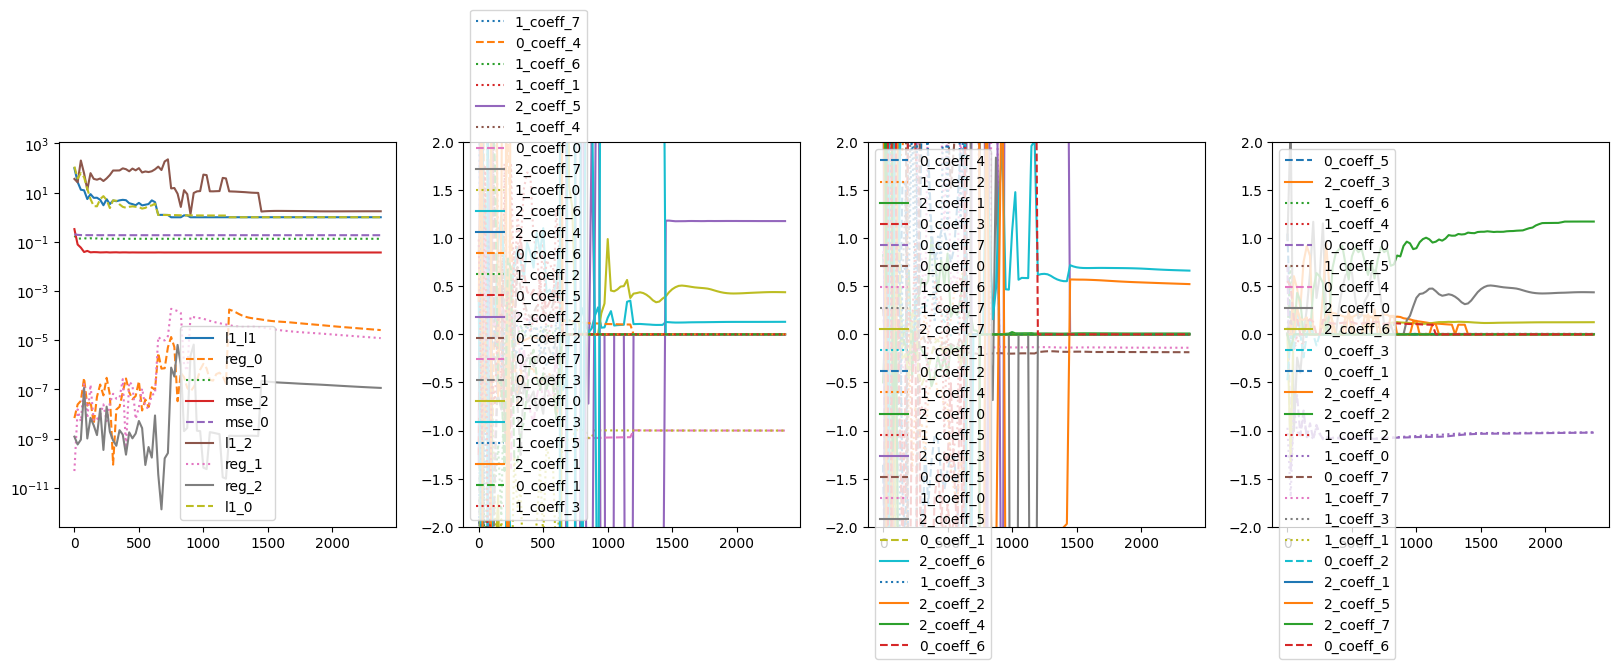

In [12]:
from deepymod.analysis import plot_history
plot_history(foldername)


In [13]:
model.sparsity_masks

[tensor([ True, False, False, False, False, False, False, False],
        device='cuda:0'),
 tensor([ True, False, False, False, False, False, False, False],
        device='cuda:0'),
 tensor([ True, False,  True, False, False, False,  True, False],
        device='cuda:0')]

In [14]:
model.constraint_coeffs()

[tensor([[-0.1856],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>),
 tensor([[-0.1392],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>),
 tensor([[0.0087],
         [0.0000],
         [0.5221],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.6620],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]